# Credit Fraud Detection

Import libraries

In [3]:
#Fundamental libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import time

%matplotlib inline
sns.set_palette(sns.color_palette())

In [4]:
#Data preparation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [5]:
#Sampling
import imblearn
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek 
from imblearn.pipeline import Pipeline

random_seed = 42

In [6]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold()

#1. Logistic Regression
from sklearn.linear_model import LogisticRegression

#2. Random Forest Classifier (Tree-Based)
from sklearn.ensemble import RandomForestClassifier

#3.XGBoost (Boosting)
from xgboost import XGBClassifier

#Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_validate

In [7]:
#Evaluation (performance) metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score 
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, f1_score

In [8]:
#Exapnd width to view dataframe
pd.set_option('max_colwidth', 400)

Functions

In [9]:
#Data Preparation

#Load data
def load_file(df): 
    """
    Reads csv file as a Pandas dataframe.
    
    Parameters
    ----------
    df: name of csv file 
    
    Returns 
    -------
    Dataframe of csv file
    
    ---
    """
    return pd.read_csv(df)

In [10]:
#Cross validation scores
def cv_scores(models, X_train, y_train, cv, scorers):
    '''
    Returns selected cross-validation (average) scores. 
    
    Parameters
    ----------
    models: list of tuples containing model name and model object [('model_name1', model_object1)]
    X_train: features training data
    y_train: target variable training data
    scorers: dictionary of selected scores [{'score_name1: score1'}]
    
    Returns
    -------
    Cross validation scores
    
    ---
    '''
    
    start_time = time.time()
    
    #Store data 
    model_names = []
    scores = []
    mean_scores = []

    for model in models: 
        score_ = cross_validate(model[1], features_train, fraud_train, scoring = scorers, cv = cv)
        for key in score_.keys():
            #Model names
            model_names.append(model[0])
            #Score
            scores.append(key)
            #Average of the score (key)
            mean_score_ = np.mean(score_[key])
            mean_scores.append(mean_score_)

    #Dataframe of scores
    model_scores = pd.DataFrame(list(zip(model_names, scores, mean_scores)))    
    model_scores.columns = ['model_name', 'score', 'mean_score']
    models_scores = model_scores.sort_values(by='score')

    #Pivot table of scores (dataframe)
    model_scores_ = pd.pivot_table(data = model_scores, index='model_name', columns='score', values='mean_score')
    #Remove name of columns 
    model_scores_.columns.name = None

    #Order of score results in 'scorer'
    score_columns = []

    for key in list(scorers.keys()):
        score_columns.append('test_'+key)

    model_scores_ = model_scores_[score_columns].reset_index()
    display(model_scores_)

    print("Execution Time: %s seconds" % (time.time() - start_time))

In [11]:
#Classification reports & confusion matrices
def class_report_conf_matrix(models, X_train, X_test, y_train, y_test):
    '''
    Classification report and confusion matrix for each estimated model
    
    Parameters
    ----------
    models: list of tuples containing model name and model object [('model_name1', model_object1)]
    X_train: features training data
    y_train: target variable training data
    X_test: features test data
    y_test: target variable test data
    
    Returns
    -------
    Classification report and confusion matrix heatmap
    
    ---
    '''
    #Classification reports & confusion matrices
    start_time = time.time()

    for model in models:  
        #Train model and make predictions
        model[1].fit(X_train, y_train)
        y_pred = model[1].predict(X_test)

        #Classification Report
        class_ = ['genuine', 'fraudulent']
        print('Model: ', model[0], '\n', classification_report(y_test, y_pred, target_names=class_))

        #Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure()
        sns.heatmap(cm, annot=True, cmap='YlGnBu', linewidths=0.1, xticklabels=class_, yticklabels=class_)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
        plt.show()
        
    print("Time taken: %s seconds" % (time.time() - start_time))

In [12]:
#Plot ROC Curves, Precision-Recall Curves and dataframe of the Areas under each curve
def eval_curves(models, X_train, X_test, y_train, y_test):
    '''
    ROC and Precision-Recall curves 
    
    Parameters
    ----------
    models: list of tuples containing model name and model object [('model_name1', model_object1)]
    X_train: features training data
    y_train: target variable training data
    X_test: features test data
    y_test: target variable test data
    y: target variable
    
    Returns
    -------
    Classification report and confusion matrix heatmap
    
    ---
    
    
    '''
    start_time = time.time()

    model_name = []
    roc_auc = []
    prc_auc = []

    #1. Subplots - setup: ROC Curves on the left, Precision-Recall Curves on the right
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    ax1.title.set_text('ROC Curves')
    ax2.title.set_text('Precision-Recall Curves')

    #1a. ROC Curves - setup
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    #No skill line: cannot differentiate b/w classes
    ax1.plot([0, 1], [0, 1], linestyle='--', color='0.8', label='No Skill')

    #1b. Precision-Recall Curves - setup
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Recall')
    #No skill line: proportion of the positive class
    no_skill = len(y_test[y_test==1]) / len(y_test)
    ax2.plot([0, 1], [no_skill, no_skill], linestyle='--', color='0.8', label='No Skill')

    #2. Curve for each model
    for model in models:
        #Model name
        model_name.append(model[0])

        #Train model and make prediction probabilities
        model[1].fit(X_train, y_train)
        y_probs = model[1].predict_proba(X_test)[:,1]

        #2a. ROC Curve
        fpr, tpr, thresholds = roc_curve(y_test, y_probs)
        ax1.plot(fpr, tpr, label = model[0])
        ax1.legend()

        roc_auc.append(roc_auc_score(y_test, y_probs))

        #2b. Precision-recall curve 
        precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
        ax2.plot(precision, recall, label = model[0])    
        plt.legend()

        prc_auc.append(auc(recall, precision))

    plt.show()

    #3. Dataframe containing areas under the ROC & precision-recall curves for each model
    auc_values = pd.DataFrame(list(zip(model_name, roc_auc, prc_auc)))
    auc_values.columns = ['Model', 'Area under ROC curve', 'Area under Precision-Recall Curve']
    display(auc_values)

    print("Time taken: %s seconds" % (time.time() - start_time))

## Data Preparation

In [68]:
#Load data
data = load_file('creditcard.csv')

In [69]:
#Data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [70]:
#Check for missing data
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

No nulls were detected and all variables except for 'Class' are floats ('Class' observations are integers).

## Exploratory Data Analysis (EDA)

In [72]:
#Summary table
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [73]:
#Split data into subsets - genuine and fraudulent transactions 

#Class = 0 (genuine)
data_0 = data[data['Class']==0]

#Class = 1 (fraudulent)
data_1 = data[data['Class']==1]

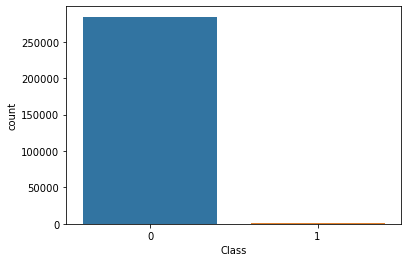

Class=0:  284315
Class=1:  492


In [86]:
#'Class' variable
sns.countplot(x='Class',data=data)
plt.savefig('class.png')
plt.show()

#Count for each class in 'Class'
print('Class=0: ', len(data_0))
print('Class=1: ', len(data_1))

In [117]:
#Number of features, i.e. variables besides the target variable, 'Class'
len(data.columns[:-1])

30

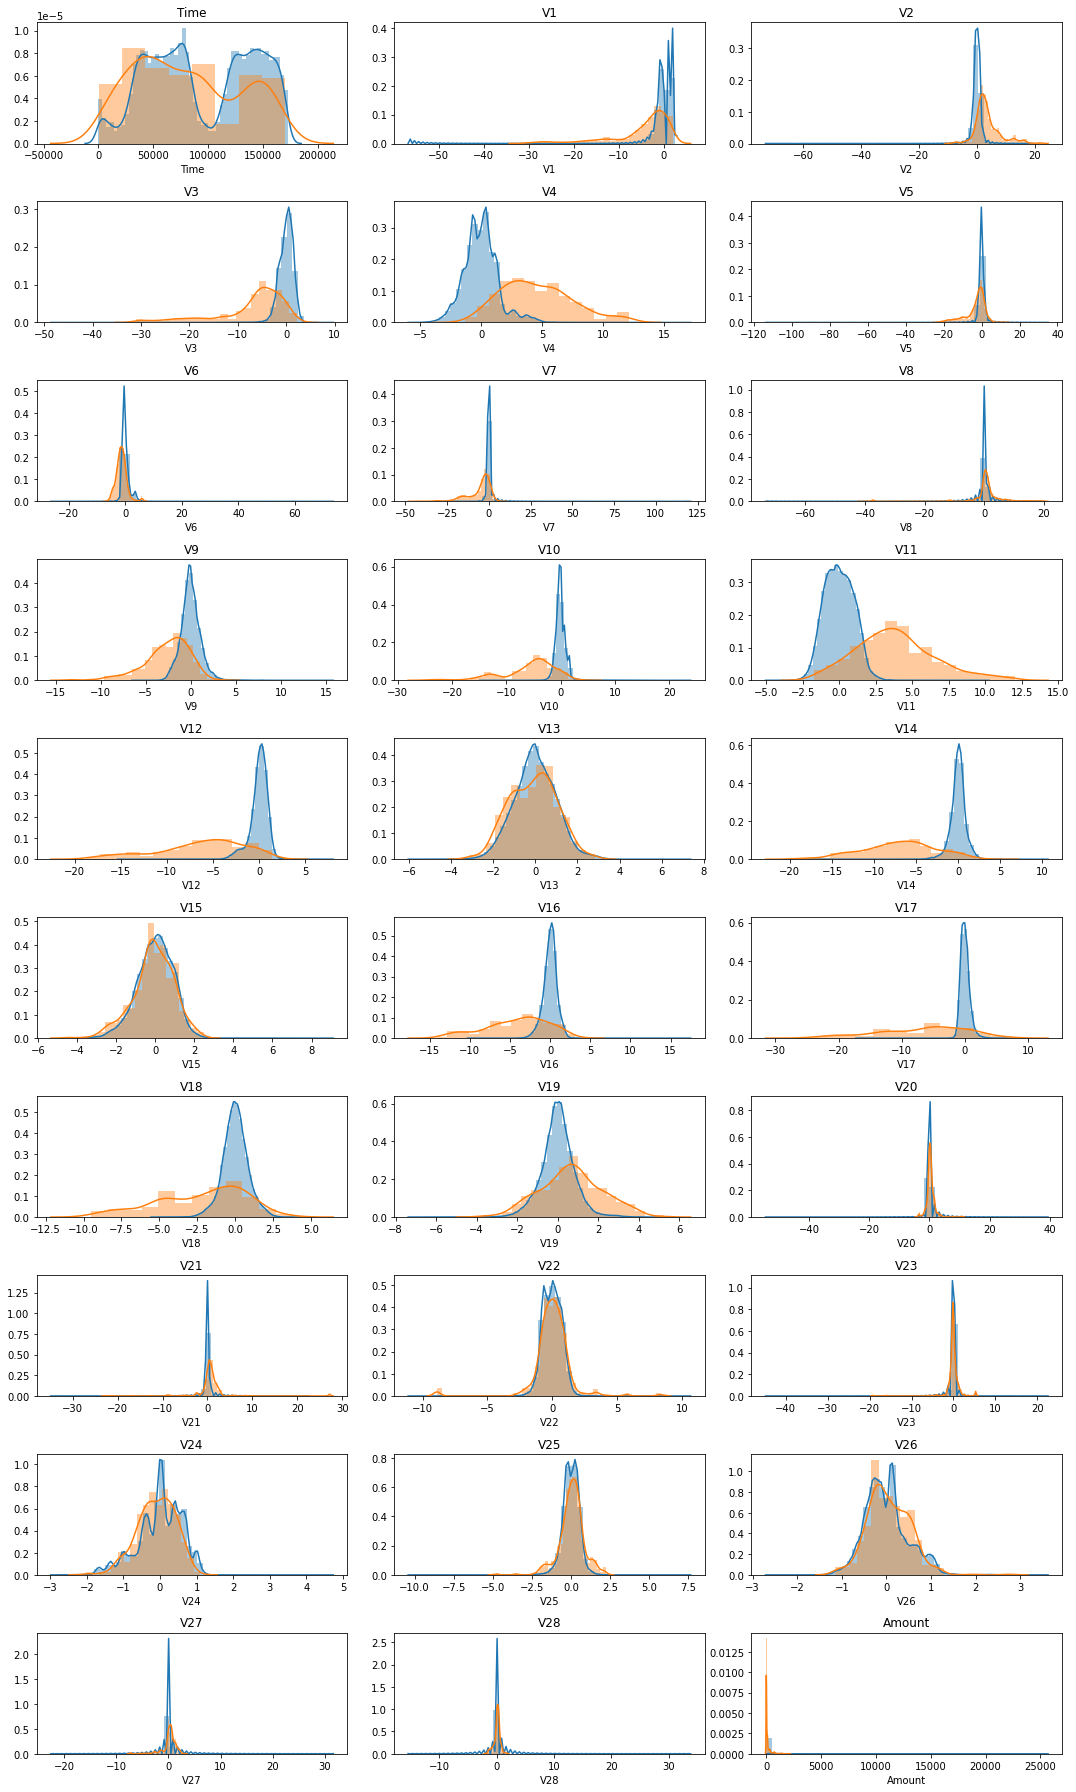

In [125]:
#Distribution plots for each class (class=0, genuine; class=1, fraudulent) within each variable
plt.figure(figsize=(15,25))

for i, column in enumerate(data.columns[:-1]):
    plt.subplot(10,3,i+1)
    plt.title(column)
    sns.distplot(data_0[column])
    sns.distplot(data_1[column])
    
plt.tight_layout()
plt.savefig('distplots.png')
plt.show()

Findings: 

* Time has a bimodal distribution for both genuine and fraudulent transactions. 
* Most variables are distributed roughly around 0, besides fradulent classes where variable distributions are different between genuine and fraudulent classes: V3, V4, V10, V11, V12, V14, V16, V17, V18.
* Class is a binary classification. 

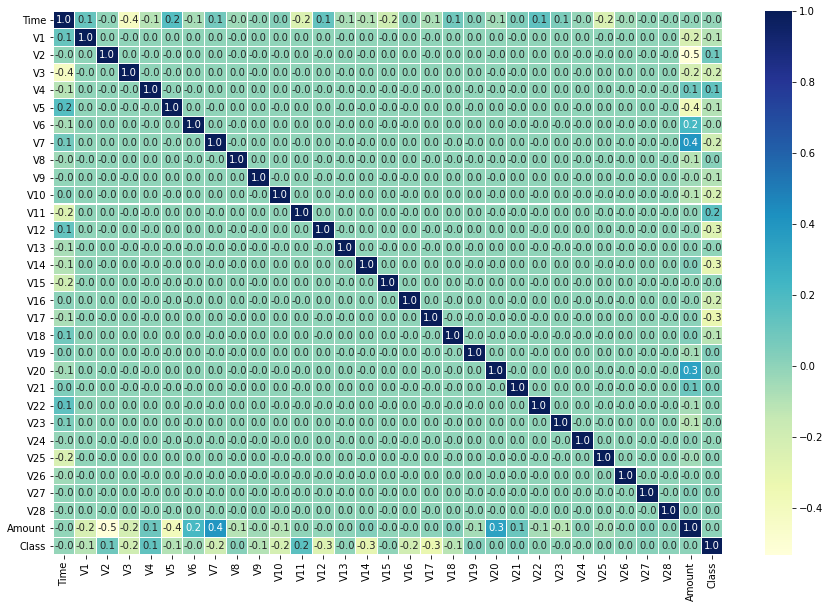

In [85]:
#Correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(), cmap='YlGnBu', linewidths=.1, annot=True, fmt='.1f')
plt.savefig('corrheatmap.png')
plt.show()

**Findings** 
* No notable correlation between the numbered variables - from V1 to V28. 
* There are noticeable correlations between 'Time' and 'Amount': 
    * 'Time': negative correlation with V3 
    * 'Amount': positive correlation with V7 and V20, and negative correlation with V2. 

#### Scatter plots and linear regressions 
Further exploration of these variables between 'Time' and 'Amount' between both classes - genuine and fraudulent transactions. 

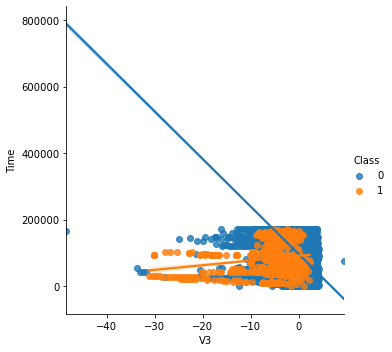

In [87]:
#V3 and Time
sns.lmplot(x="V3", y="Time", hue="Class", data=data)
plt.savefig('V3time.png')
plt.show()

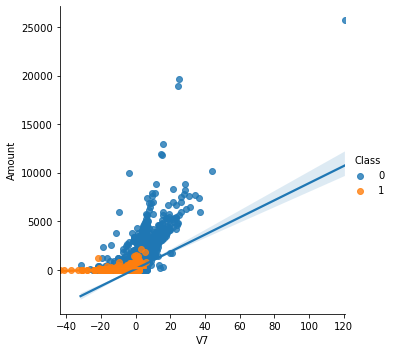

In [88]:
#V7 and Amount
sns.lmplot(x="V7", y="Amount", hue="Class", data=data)
plt.savefig('V7amount.png')
plt.show()

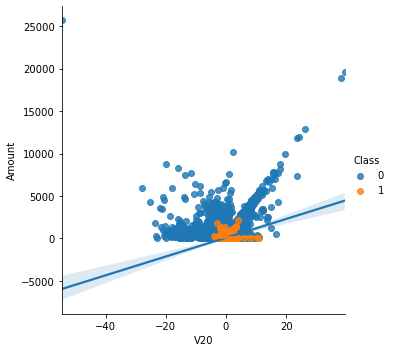

In [89]:
#V20 and Amount
sns.lmplot(x="V20", y="Amount", hue="Class", data=data)
plt.savefig('V20amount.png')
plt.show()

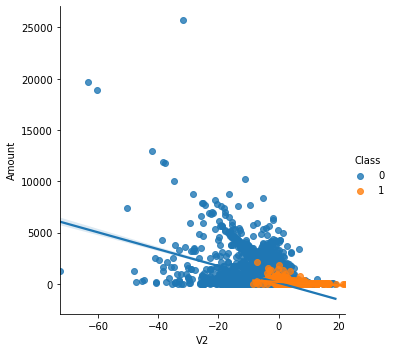

In [90]:
#V2 and Amount
sns.lmplot(x="V2", y="Amount", hue="Class", data=data)
plt.savefig('V2amount.png')
plt.show()

Only observable correlations are related to 'Amount' for genuine transactions, i.e. Class=0.   

## Feature Engineering

In [14]:
#Standardise 'Time' and 'Amount' columns - value ranges are vastly different to other feature variables

#StandardScaler on 'Time' 
s_scaler = StandardScaler()
data[['Time']] = s_scaler.fit_transform(data[['Time']])

#RobustScaler on Amount - outliers significantly different from most of the distribution
r_scaler = RobustScaler()
data[['Amount']] = r_scaler.fit_transform(data[['Amount']])

In [15]:
#Convert data to save space
data['Class'] = data['Class'].astype('int32')
data[data.columns[:-1]] = data[data.columns[:-1]].astype('float32')

## Data Preparation

In [16]:
#1. Train-test split the data (80:20); stratify train-test split as data is severely imbalanced
#2. Fit and predict the model using the training data 
#3. Evaluate predictions to the test data with a performance metric 

In [17]:
#Define X and y variables for modelling
features = data.drop(['Class'],axis=1)
fraud = data['Class']

#Train Test Split
features_train, features_test, fraud_train, fraud_test = train_test_split(features, fraud, 
                                                                            train_size=0.8,test_size=0.2, 
                                                                            random_state=random_seed, stratify = fraud)

In [18]:
#Check number of observations
print('Number of total observations: ', len(data))
print('Number of training set observations: '', features = {0:0.0f}'.format(len(features_train)), 
     '; target = {0:0.0f}'.format(len(fraud_train)))
print('Number of test set observations: '', features = {0:0.0f}'.format(len(features_test)), 
     '; target = {0:0.0f}'.format(len(fraud_test)))

Number of total observations:  284807
Number of training set observations: , features = 227845 ; target = 227845
Number of test set observations: , features = 56962 ; target = 56962


In [19]:
#To save memory space
del data

## Models

* Linear Regression, Random Forest Classifier and XGBoost Classifier were the selected models. Note that there are other classifiers, such as Support Vector Classification and Light GBM Classifier, which were not included to restrain the time length to run the codes below. 

* Weights for each model were adjusted to accommodate for the imbalanced data. 

* These models are treated as baseline models. Hyperparameter tuning of these models include coupling with various resampling techniques (and without resampling). 

* Accuracy is not an appropriate measure for imbalanced data. Thus precision, recall, F1-score, AUROC (area under the ROC curve) and AUPRC (area under the precision-recall curve) are metrics considered to evaluate model performance. 

* K-fold cross validation was involved in this process, rather than nested cross-validation to restrain the time length to run the codes below. 

In [20]:
#Models
#Linear Regression
lr = LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state=random_seed)
#'max_iter' value (10000) added to overcome the issue "STOP: TOTAL NO. of ITERATIONS REACHED LIMIT."

#Random Forest Classifier
rfc = RandomForestClassifier(class_weight = 'balanced', random_state=random_seed)

#XGBoost Classifier
#scale_pos_weight = total_negative_examples / total_positive_examples
weights = len(fraud[fraud==0]) / len(fraud[fraud==1])
xgb = XGBClassifier(random_state=random_seed, scale_pos_weight = weights, use_label_encoder=False)
#use_label_encoder=False - in repsonse to deprecation warning

#Collection of models
models = [
    ('Logistic Regression', lr), 
    ('Random Forest Classifier', rfc),
    ('XGB Classifier', xgb)
]

In [21]:
#Scores for cross-validation
scorers = {
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score),
    'ROC_AUC': 'roc_auc', 
    'PRC_AUC': 'average_precision'
}

In [27]:
#Hyperparameters
lr_params_ = {
        'model': [LogisticRegression(class_weight = 'balanced', max_iter = 10000, random_state=random_seed)],
        'model__C': [0.1, 1.0, 10]
    }

rfc_params_ = {
        'model': [RandomForestClassifier(class_weight = 'balanced', random_state=random_seed, n_jobs=-1, verbose=0)],
        'model__criterion': ['gini','entropy'],
        'model__n_estimators': [10, 100, 1000],
        'model__max_features': ['sqrt', 'log2'],
        'model__max_depth': [3, 6, 9]
    }

xgb_params_ = {
        'model': [XGBClassifier(random_state=random_seed, scale_pos_weight = weights, use_label_encoder=False, 
                                n_jobs=-1, verbosity=0)],
        'model__scale_pos_weight': [1, (227432/394), weights], #balanced weights for resampling other than Tomek Links, Tomek Links, and original sample weights for comparison
        'model__n_estimators': [10, 100, 1000],
        'model__learning_rate': [0.1, 0.3, 0.5],
        'model__max_depth': [3, 6, 9]
    }

parameters = [lr_params_, rfc_params_, xgb_params_]

In [56]:
#Cross validation scores
cv_scores(models, features_train, fraud_train, skf, scorers)

,model_name,test_Precision,test_Recall,test_F1,test_ROC_AUC,test_PRC_AUC
0,Logistic Regression,0.061654,0.916131,0.115500,0.980907,0.753420
1,Random Forest Classifier,0.951280,0.748588,0.836472,0.948944,0.835786
2,XGB Classifier,0.913743,0.822201,0.865079,0.982511,0.851396


Execution Time: 995.0141844749451 seconds


**Findings**
* Logisitc Regression has the highest Recall score, but returns a very low Precision score, F1 score and AUPRC. 
* Random Forest Classifier has the highest Precision score.
* XGBoost Classifier has the highest Recall score, F1 score, AUROC and AUPRC. 
* F1 score and AUPRC are key metrics for imbalanced data; and across these metrics overall, XGBoost Classifier is the favoured model.   

In [28]:
#Pipeline and hyperparameter tuning
start_time = time.time()

#Pipeline without resampling
pipe = Pipeline(
    steps=[
        (
            'model', LogisticRegression(class_weight = 'balanced', random_state=random_seed, max_iter = 10000)
        )
    ]
) #Initiator 

#Grid Search (Cross Validation)
gs = RandomizedSearchCV(pipe, param_distributions=parameters, cv=skf, scoring=scorers, refit='PRC_AUC')
gs.fit(features_train, fraud_train)

#Top scores
gs_ = pd.DataFrame(gs.cv_results_)

#Results dataframe
score_columns = []

for key in list(scorers.keys()):
    score_columns.append('mean_test_'+key)

gs_scores = gs_[score_columns]
gs_params_ = gs_[gs_.columns[gs_.columns.str.startswith('param')]]
gs_results = pd.concat([gs_params_, gs_scores], axis=1).sort_values('mean_test_PRC_AUC', ascending=False)

display(gs_results)

print("Execution Time: %s seconds" % (time.time() - start_time))

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
3,1,1000,6,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None,...",0.958042,0.789192,0.864752,0.982509,0.852028
2,577.876,100,9,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.8760162601626, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_d...",0.927696,0.801915,0.859854,0.982420,0.848849
5,577.239,1000,9,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 1000, 'model__max_depth': 9, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_...",0.918963,0.796819,0.852995,0.981916,0.846839
6,577.239,100,3,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_d...",0.845581,0.812042,0.827305,0.979928,0.839315
9,NaN,100,9,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,entropy,"{'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 9, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.904702,0.781629,0.837719,0.982531,0.831367
7,NaN,100,6,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,gini,"{'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'gini', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.5749

Execution Time: 2729.827306509018 seconds


### Resampling

In [27]:
#Number of train-test split observations
print('Number of training set observations: '', features = {0:0.0f}'.format(len(features_train)), 
     '; target = {0:0.0f}'.format(len(fraud_train)))
print('Number of test set observations: '', features = {0:0.0f}'.format(len(features_test)), 
     '; target = {0:0.0f}'.format(len(fraud_test)))

#Number of each class after train-test split
print('* ''{0:0.0f}'.format(fraud_train[fraud_train==1].count()), 'fraudulent observations in the training set')
print('* ''{0:0.0f}'.format(fraud_train[fraud_train==0].count()), 'genuine observations in the training set')
print('* ''{0:0.0f}'.format(fraud_test[fraud_test==1].count()), 'fraudulent observations in the test set')
print('* ''{0:0.0f}'.format(fraud_test[fraud_test==0].count()), 'genuine observations in the test set')

Number of training set observations: , features = 227845 ; target = 227845
Number of test set observations: , features = 56962 ; target = 56962
* 394 fraudulent observations in the training set
* 227451 genuine observations in the training set
* 98 fraudulent observations in the test set
* 56864 genuine observations in the test set


In [22]:
#Resampling methods
rus = RandomUnderSampler(random_state=random_seed)
tl = TomekLinks(n_jobs = -1)
ros = RandomOverSampler(random_state=random_seed)
sm = SMOTE(random_state=random_seed, n_jobs = -1)
smto = SMOTETomek(random_state=random_seed, n_jobs = -1) 

res_method = [rus, tl, ros, sm, smto]

In [30]:
#Number of observations from resampling
for resample in res_method:
    features_train_res, fraud_train_res = resample.fit_sample(features_train, fraud_train)
    
    print(resample)
    print('Number of training set observations after resampling with ' , resample, 
          ': '', features = {0:0.0f}'.format(len(features_train_res)), 
          '; target = {0:0.0f}'.format(len(fraud_train_res))
         )

    #Number of each class after resampling
    print('* ''{0:0.0f}'.format(fraud_train_res[fraud_train_res==1].count()), 'fraudulent observations in the resampled training set')
    print('* ''{0:0.0f}'.format(fraud_train_res[fraud_train_res==0].count()), 'genuine observations in the resampled training set')

RandomUnderSampler(random_state=42)
Number of training set observations after resampling with  RandomUnderSampler(random_state=42) : , features = 788 ; target = 788
* 394 fraudulent observations in the resampled training set
* 394 genuine observations in the resampled training set
TomekLinks(n_jobs=-1)
Number of training set observations after resampling with  TomekLinks(n_jobs=-1) : , features = 227826 ; target = 227826
* 394 fraudulent observations in the resampled training set
* 227432 genuine observations in the resampled training set
RandomOverSampler(random_state=42)
Number of training set observations after resampling with  RandomOverSampler(random_state=42) : , features = 454902 ; target = 454902
* 227451 fraudulent observations in the resampled training set
* 227451 genuine observations in the resampled training set
SMOTE(n_jobs=-1, random_state=42)
Number of training set observations after resampling with  SMOTE(n_jobs=-1, random_state=42) : , features = 454902 ; target = 454

In [24]:
#Metric results from pipeline to resample training data only (exc. validation data), and cross-validate with RandomizedSearchCV
def pipe_imb_gs(res_method, parameters, cv, X_train, y_train, scorers, refit_score):

    #Tuning
    start_time = time.time()

    #Pipeline
    pipe = Pipeline(
        steps=[
            ('sampling',res_method), 
            ('model', LogisticRegression(class_weight = 'balanced', random_state=random_seed))
        ]
    ) #initiator

    #Grid Search (Cross Validation)
    gs = RandomizedSearchCV(pipe, param_distributions=parameters, cv=cv, scoring=scorers, refit=refit_score)
    gs.fit(features_train, fraud_train)

    #Top scores
    gs_ = pd.DataFrame(gs.cv_results_)

    #Results dataframe
    score_columns = []

    for key in list(scorers.keys()):
        score_columns.append('mean_test_'+key)

    gs_scores = gs_[score_columns]
    gs_params_ = gs_[gs_.columns[gs_.columns.str.startswith('param')]]
    gs_results = pd.concat([gs_params_, gs_scores], axis=1).sort_values(str('mean_test_'+ refit_score), ascending=False)

    display(gs_results)

    #Best estimator (by AUPRC)
    gs.best_estimator_

    print("Execution Time: %s seconds" % (time.time() - start_time))

In [67]:
#Cross validation metrics from random under-sampling 
pipe_imb_gs(rus, parameters, skf, features_train, fraud_train, scorers, 'PRC_AUC')

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
6,NaN,100,6,NaN,"RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=6, max_features='sqrt', n_jobs=-1,\n random_state=42)",sqrt,entropy,"{'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=6, max_features='sqrt', n_jobs=-1, random_state=42)}",0.071339,0.895878,0.132115,0.977516,0.734244
7,577.876,1000,9,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estim...",NaN,NaN,"{'model__scale_pos_weight': 577.8760162601626, 'model__n_estimators': 1000, 'model__max_depth': 9, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max...",0.022036,0.936417,0.043052,0.979039,0.705654
2,1,1000,3,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estim...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_delta_step=None...",0.047783,0.908471,0.090742,0.979900,0.697931
3,577.876,100,3,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estim...",NaN,NaN,"{'model__scale_pos_weight': 577.8760162601626, 'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=None, max_...",0.020047,0.936417,0.039250,0.976438,0.697917
9,NaN,100,3,NaN,"RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=6, max_features='sqrt', n_jobs=-1,\n random_state=42)",log2,entropy,"{'model__n_estimators': 100, 'model__max_features': 'log2', 'model__max_depth': 3, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=6, max_features='sqrt', n_jobs=-1, random_state=42)}",0.135431,0.855242,0.233656,0.974389,0.687215
4,1,10,6,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=None, max_delta_step=None, max_depth=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estim...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 10, 'model__max_depth': 6, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_

Execution Time: 26.43189024925232 seconds


In [26]:
#Cross validation metrics from under-sampling using Tomek Links 
pipe_imb_gs(tl, parameters, skf, features_train, fraud_train, scorers, 'PRC_AUC')

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
0,577.876,100,6,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.8760162601626, 'model__n_estimators': 100, 'model__max_depth': 6, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_d...",0.895666,0.809542,0.849636,0.979404,0.848363
6,1,1000,3,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_delta_step=None,...",0.928457,0.786725,0.851554,0.984238,0.846118
5,NaN,1000,6,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,entropy,"{'model__n_estimators': 1000, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.702833,0.829828,0.759945,0.984243,0.810406
3,NaN,100,6,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,entropy,"{'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.678145,0.824765,0.743861,0.982520,0.803465
4,NaN,10,6,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,entropy,"{'model__n_estimators': 10, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.597644,0.832360,0.694913,0.975192,0.793954
9,577.239,10,6,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 10, 'model__max_depth': 6, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_de...",0.367525,0.834924,0.509866,0.969441,0.743920
2,NaN,10,3,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",sqrt,entropy,"{'model__n_estimators': 10, 'model__max_features': 'sqrt', 'model__max_depth': 3, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.129734,0.852645,0.224648,0.968978,0.727711
1,577.239,10,3,0.5,"X

Execution Time: 56206.580171346664 seconds


In [69]:
#Cross validation metrics from random over-sampling 
pipe_imb_gs(ros, parameters, skf, features_train, fraud_train, scorers, 'PRC_AUC')

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
1,1,1000,3,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=3,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None,...",0.923269,0.819669,0.868017,0.982739,0.849754
4,1,100,9,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=3,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None, ...",0.917031,0.801947,0.855251,0.984218,0.843855
0,577.876,100,9,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=3,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.8760162601626, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_d...",0.857863,0.804479,0.829658,0.958946,0.825601
8,577.239,100,9,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=3,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_d...",0.835180,0.804479,0.818349,0.960542,0.821229
6,NaN,100,6,NaN,"RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=6, max_features='sqrt', n_jobs=-1,\n random_state=42)",sqrt,entropy,"{'model__n_estimators': 100, 'model__max_features': 'sqrt', 'model__max_depth': 6, 'model__criterion': 'entropy', 'model': RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=6, max_features='sqrt', n_jobs=-1, random_state=42)}",0.489604,0.852613,0.617814,0.981734,0.814813
7,NaN,1000,9,NaN,"RandomForestClassifier(class_weight='balanced', criterion='entropy',\n max_depth=6, max_features='sqrt', n_jobs=-1,\n random_state=42)",sqrt,gini,"{'model__n_estimators': 1000, 'model_

Execution Time: 7181.651693820953 seconds


In [70]:
#Cross validation metrics from SMOTE - over-sampling using SMOTE
pipe_imb_gs(sm, parameters, skf, features_train, fraud_train, scorers, 'PRC_AUC')

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
4,1,1000,6,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None,...",0.836762,0.824732,0.830298,0.979214,0.849351
3,1,1000,9,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 9, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None,...",0.812935,0.824700,0.818054,0.978999,0.846351
2,1,1000,6,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 1000, 'model__max_depth': 6, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_delta_step=None,...",0.831078,0.819669,0.824968,0.981573,0.843663
6,577.239,1000,3,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 1000, 'model__max_depth': 3, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.1, max_...",0.666211,0.832360,0.738502,0.974338,0.836787
7,577.239,100,9,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.1, max_delta_step=None, max_depth=6,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interac

Execution Time: 12537.23425936699 seconds


In [25]:
#Cross validation metrics from SMOTETomek - over-sampling using SMOTE and cleaning using Tomek links
pipe_imb_gs(smto, parameters, skf, features_train, fraud_train, scorers, 'PRC_AUC')

,param_model__scale_pos_weight,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model,param_model__max_features,param_model__criterion,params,mean_test_Precision,mean_test_Recall,mean_test_F1,mean_test_ROC_AUC,mean_test_PRC_AUC
3,1,100,9,0.5,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=9,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.5, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_delta_step=None, ...",0.788984,0.827264,0.807288,0.977423,0.844292
8,1,100,9,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=9,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 1, 'model__n_estimators': 100, 'model__max_depth': 9, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_delta_step=None, ...",0.642902,0.824732,0.721590,0.977422,0.839485
1,577.239,1000,6,0.1,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=9,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 1000, 'model__max_depth': 6, 'model__learning_rate': 0.1, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_...",0.687774,0.827264,0.749963,0.974783,0.832756
7,577.239,1000,6,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=9,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n n_estimator...",NaN,NaN,"{'model__scale_pos_weight': 577.2385786802031, 'model__n_estimators': 1000, 'model__max_depth': 6, 'model__learning_rate': 0.3, 'model': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, gamma=None, gpu_id=None, importance_type='gain', interaction_constraints=None, learning_rate=0.5, max_...",0.671362,0.829796,0.740654,0.975727,0.830773
2,NaN,1000,9,NaN,"RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)",log2,gini,"{'model__n_estimators': 1000, 'model__max_features': 'log2', 'model__max_depth': 9, 'model__criterion': 'gini', 'model': RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)}",0.419969,0.842486,0.554840,0.984790,0.806693
5,577.876,100,3,0.3,"XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,\n colsample_bynode=None, colsample_bytree=None, gamma=None,\n gpu_id=None, importance_type='gain', interaction_constraints=None,\n learning_rate=0.5, max_delta_step=None, max_depth=9,\n min_child_weight=None, missing=nan, monoton

Execution Time: 226967.80654501915 seconds


### Evlauation metrics 

Accuracy is not an appropriate metric for imbalanced data, so precision, recall, F1 score, AUROC score and AUPRC score were suitable metrics selected to determine the best model(s). Optimal thresholds were not assessed during cross-validation as the area-under-curve metrics were chosen the determine the best models overall, rather at a specific threshold. 

The best model to deploy is ideally one with the highest scores for all metrics. Unfortunately, our results showed otherwise; further decisions were required to select the best model to deploy. To break down the decision-making process to select the best deployable model, only recall, the F1 score and AUPRC score were the key metrics based on the following points.

* High AUROC scores were likely to occur with imbalanced data. Our AUROC scores reflected this with AUROC scores not varying significantly across the models. As a result, it was not a metric that weighed much value in determining the best model(s) going forward. 

* AUPRC scores were not affected by the nature of imbalanced data so it had a greater focus than AUROC scores. 

* Recall had a greater focus than precision as false negatives of credit card fraud had a greater implications than false positives. 

* F1 scores: some models had significantly high recall, but traded off with unacceptable low precision scores. F1 scores were a harmonic average of precision and recall, so they were an appropriate metric to prioritise and consider.   

### Best models
Note: scores mentioned here are based on average validation scores.

Three models below showed an overall high across all metrics, coupled with at least one of the highest prioritised scores (based on the above - i.e. recall, F1 score and AUPRC score). 

* XGBoost Classifier (without resampling): n_estimators = 1000, max_depth = 6, learning_rate = 0.1, and scale_pos_weight=1
    * This model indicated the highest AUPRC score and the fasted time to deploy, but at a significant cost of performing the least well in terms of recall. 
* With random over-sampling, XGBoost Classifier: n_estimators = 1000, max_depth = 3, learning_rate = 0.1, and scale_pos_weight=1
    * This model indicated the highest F1-score and moderate recall and AUPRC scores (moderate as in second best between the three models mentioned here).
* From SMOTE-Tomek resampling, XGBoost Classifier: n_estimators = 100, max_depth = 9, learning_rate = 0.5, and scale_pos_weight=1
    * This model indicated the highest recall score, but does not perform as well across the rest of the metrics in comparison to the models above.

### Best model
Based on the results of the models above, the XGBoost Classifiers with random over-sampling and without sampling are weighed as preferrable models, as they both provided relatively higher F1 scores and AUPRC scores. However, these high scores of the XGBoost Classifier without resampling do come at the cost of a significantly lower recall score, which could not be overlooked to justify it as the best model going foward. As a result, the the **XGBoost Classifier with random over-sampling** was selected as the best model. 

### Next steps
All three models were evaluated using the test data to check for their robustness and for overfitting in unseen data. All three were considered as a final affirmation of our decision in case the best model does not fair well with unseen data. 

### Model evaluation

In [59]:
#Without resampling
xgb_ = XGBClassifier(n_estimators = 1000, max_depth = 6, learning_rate = 0.1, scale_pos_weight=1,
              random_state=random_seed, use_label_encoder=False, n_jobs=-1, verbosity=0)

#Random Over-Sampling
pipe_ros = Pipeline(
    steps=[
        ('sampling',ros), 
        ('model', XGBClassifier(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, scale_pos_weight=1,
              random_state=random_seed, use_label_encoder=False, n_jobs=-1, verbosity=0))
    ]
)

#SMOTE-Tomek resampling
pipe_smto = Pipeline(
    steps=[
        ('sampling',smto), 
        ('model', XGBClassifier(n_estimators = 100, max_depth = 9, learning_rate = 0.5, scale_pos_weight=1,
              random_state=random_seed, use_label_encoder=False, n_jobs=-1, verbosity=0))
    ]
)

models_ = [
    ('XGBoost Classifer without resampling', xgb_), 
    ('XGBoost Classifer with random over-sampling', pipe_ros), 
    ('XGBoost Classifer with SMOTE-Tomek resampling', pipe_smto)
]

Model:  XGBoost Classifer without resampling 
               precision    recall  f1-score   support

     genuine       1.00      1.00      1.00     56864
  fraudulent       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



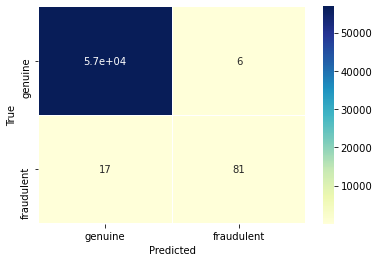

Model:  XGBoost Classifer with random over-sampling 
               precision    recall  f1-score   support

     genuine       1.00      1.00      1.00     56864
  fraudulent       0.87      0.86      0.86        98

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962



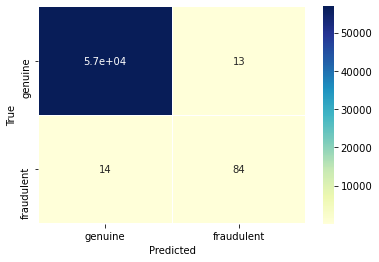

Model:  XGBoost Classifer with SMOTE-Tomek resampling 
               precision    recall  f1-score   support

     genuine       1.00      1.00      1.00     56864
  fraudulent       0.78      0.87      0.82        98

    accuracy                           1.00     56962
   macro avg       0.89      0.93      0.91     56962
weighted avg       1.00      1.00      1.00     56962



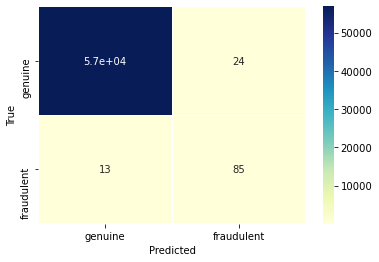

Time taken: 7512.9242351055145 seconds


In [60]:
#Classification reports and confusion matrices
class_report_conf_matrix(models_, features_train, features_test, fraud_train, fraud_test)

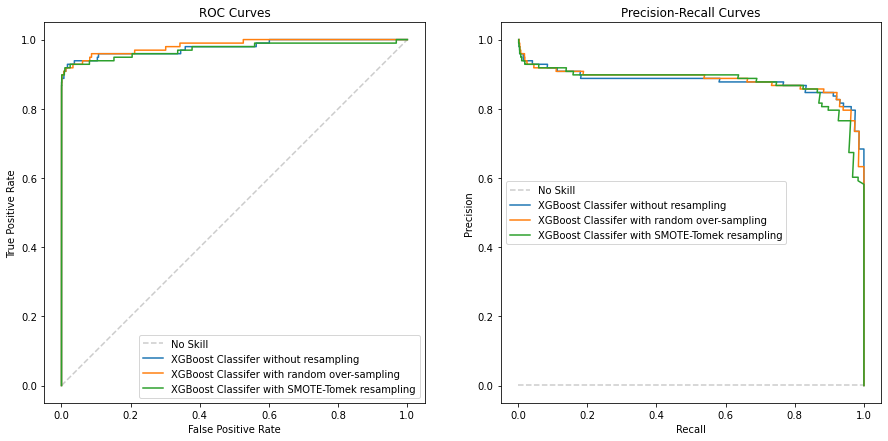

,Model,Area under ROC curve,Area under Precision-Recall Curve
0,XGBoost Classifer without resampling,0.977952,0.878566
1,XGBoost Classifer with random over-sampling,0.982989,0.881313
2,XGBoost Classifer with SMOTE-Tomek resampling,0.972202,0.874844


Time taken: 8478.618636369705 seconds


In [62]:
#Plot ROC Curves, Precision-Recall Curves and dataframe of the Areas under each curve
eval_curves(models_, features_train, features_test, fraud_train, fraud_test)

The evaluation of the selected models on the test data above showed similar results to the k-fold cross validation. These results reflect robustness of the models to unseen data and no red flags of overfitting. 

* These results above also reaffirm that the XGBoost Classifiers with random over-sampling and without resampling both perform better than the XGBoost Classifiers with SMOTE-Tomek resampling; and that the XGBoost Classifier with random over-sampling performs well without the cost of a lower recall score as shown by the XGBoost Classifier without resampling. 
* Hence, the **XGBoost Classifier with random oversampling** is the best model to deploy.

## Deployed Solution

In [67]:
#Deployed model: 
#Random over-sampling, 
#XGBClassifier(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, scale_pos_weight=1,
#              random_state=random_seed, use_label_encoder=False, n_jobs=-1, verbosity=0) 
pipe_ros

Pipeline(steps=[('sampling', RandomOverSampler(random_state=42)),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=1000,
                               n_jobs=-1, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               use_label_encoder=False, validate_parameters=1,
                               verbosity=0))])

## Appendix

In [126]:
#Markdown table of descriptive stats for each variable
data.describe().to_markdown()

'|       |     Time |               V1 |               V2 |               V3 |               V4 |               V5 |               V6 |               V7 |               V8 |               V9 |              V10 |              V11 |              V12 |              V13 |              V14 |              V15 |              V16 |              V17 |              V18 |              V19 |             V20 |              V21 |              V22 |              V23 |              V24 |            V25 |             V26 |              V27 |              V28 |      Amount |           Class |\n|:------|---------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|-----------------:|----------------:|-----------------: